##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TF Lite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

2021-07-10 11:09:41.908423: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


2021-07-10 11:09:43.415190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-07-10 11:09:43.416714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-10 11:09:44.071543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-10 11:09:44.072487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: NVIDIA Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-10 11:09:44.072568: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-10 11:09:44.077666: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-10 11:09:44.077764: I tensorflow/stream_executor

## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [3]:
model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/1",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/1",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/1",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/1",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/1",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/1",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/1",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/1",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/1",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/1",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/1",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/1",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE =  16#@param {type:"integer"}

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1
Input size (384, 384)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 3s

  8396800/228813984 [>.............................] - ETA: 23s

 19357696/228813984 [=>............................] - ETA: 10s

 32743424/228813984 [===>..........................] - ETA: 5s 

 41951232/228813984 [====>.........................] - ETA: 7s

 54222848/228813984 [======>.......................] - ETA: 5s

 60669952/228813984 [======>.......................] - ETA: 5s

 67117056/228813984 [=======>......................] - ETA: 4s

 75505664/228813984 [========>.....................] - ETA: 6s

 83894272/228813984 [=========>....................] - ETA: 6s

 91398144/228813984 [==========>...................] - ETA: 5s

106946560/228813984 [=============>................] - ETA: 4s

109060096/228813984 [=============>................] - ETA: 5s

119037952/228813984 [==============>...............] - ETA: 4s

127000576/228813984 [===============>..............] - ETA: 4s

141910016/228813984 [=================>............] - ETA: 3s

142614528/228813984 [=================>............] - ETA: 3s

151003136/228813984 [==================>...........] - ETA: 2s

162562048/228813984 [====================>.........] - ETA: 2s

167780352/228813984 [====================>.........] - ETA: 2s

176168960/228813984 [======================>.......] - ETA: 1s

184557568/228813984 [=======================>......] - ETA: 1s

198246400/228813984 [========================>.....] - ETA: 1s

201334784/228813984 [=========================>....] - ETA: 0s

215400448/228813984 [===========================>..] - ETA: 0s

218112000/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 7s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2021-07-10 11:09:55.068048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-10 11:09:55.068753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: NVIDIA Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-10 11:09:55.068865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-10 11:09:55.069469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-10 11:09:55.070075: I tensorflow/core/c

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              20331360  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 20,337,765
Trainable params: 6,405
Non-trainable params: 20,331,360
_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


2021-07-10 11:10:12.421017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-10 11:10:12.421548: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000194999 Hz


2021-07-10 11:10:21.888082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2021-07-10 11:10:23.880143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


2021-07-10 11:10:29.026270: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2021-07-10 11:10:29.386777: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


  1/183 [..............................] - ETA: 53:29 - loss: 1.7005 - accuracy: 0.1250

  2/183 [..............................] - ETA: 11s - loss: 1.7788 - accuracy: 0.0625  

  3/183 [..............................] - ETA: 11s - loss: 1.7416 - accuracy: 0.0833

  4/183 [..............................] - ETA: 11s - loss: 1.7296 - accuracy: 0.0938

  5/183 [..............................] - ETA: 11s - loss: 1.7121 - accuracy: 0.1500

  6/183 [..............................] - ETA: 11s - loss: 1.7070 - accuracy: 0.1667

  7/183 [>.............................] - ETA: 11s - loss: 1.6955 - accuracy: 0.1875

  8/183 [>.............................] - ETA: 11s - loss: 1.6728 - accuracy: 0.2188

  9/183 [>.............................] - ETA: 11s - loss: 1.6405 - accuracy: 0.2500

 10/183 [>.............................] - ETA: 11s - loss: 1.6102 - accuracy: 0.2688

 11/183 [>.............................] - ETA: 11s - loss: 1.5835 - accuracy: 0.2955

 12/183 [>.............................] - ETA: 10s - loss: 1.5697 - accuracy: 0.3021

 13/183 [=>............................] - ETA: 10s - loss: 1.5486 - accuracy: 0.3173

 14/183 [=>............................] - ETA: 10s - loss: 1.5315 - accuracy: 0.3304

 15/183 [=>............................] - ETA: 10s - loss: 1.5019 - accuracy: 0.3458

 16/183 [=>............................] - ETA: 10s - loss: 1.4831 - accuracy: 0.3594

 17/183 [=>............................] - ETA: 10s - loss: 1.4621 - accuracy: 0.3750

 18/183 [=>............................] - ETA: 10s - loss: 1.4522 - accuracy: 0.3854

 19/183 [==>...........................] - ETA: 10s - loss: 1.4187 - accuracy: 0.4079

 20/183 [==>...........................] - ETA: 10s - loss: 1.3954 - accuracy: 0.4281

 21/183 [==>...........................] - ETA: 10s - loss: 1.3775 - accuracy: 0.4435

 22/183 [==>...........................] - ETA: 10s - loss: 1.3605 - accuracy: 0.4574

 23/183 [==>...........................] - ETA: 10s - loss: 1.3500 - accuracy: 0.4674

 24/183 [==>...........................] - ETA: 10s - loss: 1.3363 - accuracy: 0.4766

 25/183 [===>..........................] - ETA: 10s - loss: 1.3149 - accuracy: 0.4925

 26/183 [===>..........................] - ETA: 10s - loss: 1.2964 - accuracy: 0.5048

 27/183 [===>..........................] - ETA: 9s - loss: 1.2852 - accuracy: 0.5116 

 28/183 [===>..........................] - ETA: 9s - loss: 1.2728 - accuracy: 0.5223

 29/183 [===>..........................] - ETA: 9s - loss: 1.2655 - accuracy: 0.5280

 30/183 [===>..........................] - ETA: 9s - loss: 1.2457 - accuracy: 0.5417

 31/183 [====>.........................] - ETA: 9s - loss: 1.2309 - accuracy: 0.5524

 32/183 [====>.........................] - ETA: 9s - loss: 1.2190 - accuracy: 0.5586

 33/183 [====>.........................] - ETA: 9s - loss: 1.2080 - accuracy: 0.5682

 34/183 [====>.........................] - ETA: 9s - loss: 1.1988 - accuracy: 0.5735

 35/183 [====>.........................] - ETA: 9s - loss: 1.1910 - accuracy: 0.5786

 36/183 [====>.........................] - ETA: 9s - loss: 1.1797 - accuracy: 0.5833

 37/183 [=====>........................] - ETA: 9s - loss: 1.1696 - accuracy: 0.5912

 38/183 [=====>........................] - ETA: 9s - loss: 1.1572 - accuracy: 0.5987

 39/183 [=====>........................] - ETA: 9s - loss: 1.1436 - accuracy: 0.6074

 40/183 [=====>........................] - ETA: 9s - loss: 1.1340 - accuracy: 0.6141

 41/183 [=====>........................] - ETA: 9s - loss: 1.1300 - accuracy: 0.6143

 42/183 [=====>........................] - ETA: 8s - loss: 1.1207 - accuracy: 0.6205

 43/183 [======>.......................] - ETA: 8s - loss: 1.1138 - accuracy: 0.6250

 44/183 [======>.......................] - ETA: 8s - loss: 1.1073 - accuracy: 0.6293

 45/183 [======>.......................] - ETA: 8s - loss: 1.1010 - accuracy: 0.6347

 46/183 [======>.......................] - ETA: 8s - loss: 1.0941 - accuracy: 0.6399

 47/183 [======>.......................] - ETA: 8s - loss: 1.0877 - accuracy: 0.6449

 48/183 [======>.......................] - ETA: 8s - loss: 1.0800 - accuracy: 0.6484

 49/183 [=======>......................] - ETA: 8s - loss: 1.0718 - accuracy: 0.6531

 50/183 [=======>......................] - ETA: 8s - loss: 1.0642 - accuracy: 0.6575

 51/183 [=======>......................] - ETA: 8s - loss: 1.0570 - accuracy: 0.6618

 52/183 [=======>......................] - ETA: 8s - loss: 1.0503 - accuracy: 0.6647

 53/183 [=======>......................] - ETA: 8s - loss: 1.0440 - accuracy: 0.6686

 54/183 [=======>......................] - ETA: 8s - loss: 1.0366 - accuracy: 0.6736

 55/183 [========>.....................] - ETA: 8s - loss: 1.0275 - accuracy: 0.6795

 56/183 [========>.....................] - ETA: 8s - loss: 1.0206 - accuracy: 0.6853

 57/183 [========>.....................] - ETA: 8s - loss: 1.0151 - accuracy: 0.6886

 58/183 [========>.....................] - ETA: 7s - loss: 1.0104 - accuracy: 0.6929

 59/183 [========>.....................] - ETA: 7s - loss: 1.0065 - accuracy: 0.6949

 60/183 [========>.....................] - ETA: 7s - loss: 1.0006 - accuracy: 0.6979

 61/183 [=========>....................] - ETA: 7s - loss: 0.9965 - accuracy: 0.6998

 62/183 [=========>....................] - ETA: 7s - loss: 0.9930 - accuracy: 0.7016

 63/183 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.7044

 64/183 [=========>....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.7070

 65/183 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.7087

 66/183 [=========>....................] - ETA: 7s - loss: 0.9763 - accuracy: 0.7121

 67/183 [=========>....................] - ETA: 7s - loss: 0.9703 - accuracy: 0.7164

 68/183 [==========>...................] - ETA: 7s - loss: 0.9661 - accuracy: 0.7188

 69/183 [==========>...................] - ETA: 7s - loss: 0.9628 - accuracy: 0.7210

 70/183 [==========>...................] - ETA: 7s - loss: 0.9573 - accuracy: 0.7250

 71/183 [==========>...................] - ETA: 7s - loss: 0.9542 - accuracy: 0.7271

 72/183 [==========>...................] - ETA: 7s - loss: 0.9518 - accuracy: 0.7283

 73/183 [==========>...................] - ETA: 7s - loss: 0.9477 - accuracy: 0.7320

 74/183 [===========>..................] - ETA: 6s - loss: 0.9441 - accuracy: 0.7348

 75/183 [===========>..................] - ETA: 6s - loss: 0.9433 - accuracy: 0.7358

 76/183 [===========>..................] - ETA: 6s - loss: 0.9391 - accuracy: 0.7385

 77/183 [===========>..................] - ETA: 6s - loss: 0.9383 - accuracy: 0.7378

 78/183 [===========>..................] - ETA: 6s - loss: 0.9357 - accuracy: 0.7396

 79/183 [===========>..................] - ETA: 6s - loss: 0.9328 - accuracy: 0.7421

 80/183 [============>.................] - ETA: 6s - loss: 0.9318 - accuracy: 0.7414

 81/183 [============>.................] - ETA: 6s - loss: 0.9317 - accuracy: 0.7415

 82/183 [============>.................] - ETA: 6s - loss: 0.9278 - accuracy: 0.7424

 83/183 [============>.................] - ETA: 6s - loss: 0.9258 - accuracy: 0.7432

 84/183 [============>.................] - ETA: 6s - loss: 0.9229 - accuracy: 0.7455

 85/183 [============>.................] - ETA: 6s - loss: 0.9204 - accuracy: 0.7463

 86/183 [=============>................] - ETA: 6s - loss: 0.9190 - accuracy: 0.7478

 87/183 [=============>................] - ETA: 6s - loss: 0.9157 - accuracy: 0.7507

 88/183 [=============>................] - ETA: 6s - loss: 0.9130 - accuracy: 0.7521

 89/183 [=============>................] - ETA: 5s - loss: 0.9118 - accuracy: 0.7521

 90/183 [=============>................] - ETA: 5s - loss: 0.9102 - accuracy: 0.7528

 91/183 [=============>................] - ETA: 5s - loss: 0.9082 - accuracy: 0.7534

 92/183 [==============>...............] - ETA: 5s - loss: 0.9062 - accuracy: 0.7541

 93/183 [==============>...............] - ETA: 5s - loss: 0.9055 - accuracy: 0.7540

 94/183 [==============>...............] - ETA: 5s - loss: 0.9026 - accuracy: 0.7566

 95/183 [==============>...............] - ETA: 5s - loss: 0.9015 - accuracy: 0.7579

 96/183 [==============>...............] - ETA: 5s - loss: 0.8983 - accuracy: 0.7591

 97/183 [==============>...............] - ETA: 5s - loss: 0.8978 - accuracy: 0.7584

 98/183 [===============>..............] - ETA: 5s - loss: 0.8978 - accuracy: 0.7570

 99/183 [===============>..............] - ETA: 5s - loss: 0.8958 - accuracy: 0.7582

100/183 [===============>..............] - ETA: 5s - loss: 0.8949 - accuracy: 0.7581

101/183 [===============>..............] - ETA: 5s - loss: 0.8911 - accuracy: 0.7605

102/183 [===============>..............] - ETA: 5s - loss: 0.8898 - accuracy: 0.7616

103/183 [===============>..............] - ETA: 5s - loss: 0.8871 - accuracy: 0.7627

104/183 [================>.............] - ETA: 5s - loss: 0.8854 - accuracy: 0.7638

105/183 [================>.............] - ETA: 4s - loss: 0.8833 - accuracy: 0.7649

106/183 [================>.............] - ETA: 4s - loss: 0.8821 - accuracy: 0.7665

107/183 [================>.............] - ETA: 4s - loss: 0.8802 - accuracy: 0.7681

108/183 [================>.............] - ETA: 4s - loss: 0.8787 - accuracy: 0.7685

109/183 [================>.............] - ETA: 4s - loss: 0.8763 - accuracy: 0.7701

110/183 [=================>............] - ETA: 4s - loss: 0.8758 - accuracy: 0.7705

111/183 [=================>............] - ETA: 4s - loss: 0.8742 - accuracy: 0.7708

112/183 [=================>............] - ETA: 4s - loss: 0.8719 - accuracy: 0.7723

113/183 [=================>............] - ETA: 4s - loss: 0.8720 - accuracy: 0.7721

114/183 [=================>............] - ETA: 4s - loss: 0.8701 - accuracy: 0.7736

115/183 [=================>............] - ETA: 4s - loss: 0.8686 - accuracy: 0.7745

116/183 [==================>...........] - ETA: 4s - loss: 0.8666 - accuracy: 0.7759

117/183 [==================>...........] - ETA: 4s - loss: 0.8662 - accuracy: 0.7762

118/183 [==================>...........] - ETA: 4s - loss: 0.8640 - accuracy: 0.7775

119/183 [==================>...........] - ETA: 4s - loss: 0.8619 - accuracy: 0.7784

120/183 [==================>...........] - ETA: 4s - loss: 0.8618 - accuracy: 0.7781

121/183 [==================>...........] - ETA: 3s - loss: 0.8603 - accuracy: 0.7789

122/183 [===================>..........] - ETA: 3s - loss: 0.8586 - accuracy: 0.7797

123/183 [===================>..........] - ETA: 3s - loss: 0.8573 - accuracy: 0.7800

124/183 [===================>..........] - ETA: 3s - loss: 0.8577 - accuracy: 0.7802

125/183 [===================>..........] - ETA: 3s - loss: 0.8558 - accuracy: 0.7815

126/183 [===================>..........] - ETA: 3s - loss: 0.8548 - accuracy: 0.7817

127/183 [===================>..........] - ETA: 3s - loss: 0.8516 - accuracy: 0.7835

128/183 [===================>..........] - ETA: 3s - loss: 0.8496 - accuracy: 0.7847

129/183 [====================>.........] - ETA: 3s - loss: 0.8485 - accuracy: 0.7849

130/183 [====================>.........] - ETA: 3s - loss: 0.8467 - accuracy: 0.7865

131/183 [====================>.........] - ETA: 3s - loss: 0.8457 - accuracy: 0.7872

132/183 [====================>.........] - ETA: 3s - loss: 0.8440 - accuracy: 0.7874

133/183 [====================>.........] - ETA: 3s - loss: 0.8419 - accuracy: 0.7885

134/183 [====================>.........] - ETA: 3s - loss: 0.8402 - accuracy: 0.7896

135/183 [=====================>........] - ETA: 3s - loss: 0.8390 - accuracy: 0.7903

136/183 [=====================>........] - ETA: 2s - loss: 0.8370 - accuracy: 0.7918

137/183 [=====================>........] - ETA: 2s - loss: 0.8355 - accuracy: 0.7924

138/183 [=====================>........] - ETA: 2s - loss: 0.8343 - accuracy: 0.7930

139/183 [=====================>........] - ETA: 2s - loss: 0.8339 - accuracy: 0.7936

140/183 [=====================>........] - ETA: 2s - loss: 0.8326 - accuracy: 0.7942

141/183 [======================>.......] - ETA: 2s - loss: 0.8334 - accuracy: 0.7939

142/183 [======================>.......] - ETA: 2s - loss: 0.8319 - accuracy: 0.7949

143/183 [======================>.......] - ETA: 2s - loss: 0.8309 - accuracy: 0.7955

144/183 [======================>.......] - ETA: 2s - loss: 0.8299 - accuracy: 0.7964

145/183 [======================>.......] - ETA: 2s - loss: 0.8307 - accuracy: 0.7961

146/183 [======================>.......] - ETA: 2s - loss: 0.8304 - accuracy: 0.7971

147/183 [=======================>......] - ETA: 2s - loss: 0.8301 - accuracy: 0.7972

148/183 [=======================>......] - ETA: 2s - loss: 0.8293 - accuracy: 0.7977

149/183 [=======================>......] - ETA: 2s - loss: 0.8289 - accuracy: 0.7974

150/183 [=======================>......] - ETA: 2s - loss: 0.8290 - accuracy: 0.7979

151/183 [=======================>......] - ETA: 2s - loss: 0.8288 - accuracy: 0.7980

152/183 [=======================>......] - ETA: 1s - loss: 0.8273 - accuracy: 0.7989

153/183 [========================>.....] - ETA: 1s - loss: 0.8260 - accuracy: 0.7994

154/183 [========================>.....] - ETA: 1s - loss: 0.8254 - accuracy: 0.8003

155/183 [========================>.....] - ETA: 1s - loss: 0.8235 - accuracy: 0.8016

156/183 [========================>.....] - ETA: 1s - loss: 0.8227 - accuracy: 0.8025

157/183 [========================>.....] - ETA: 1s - loss: 0.8216 - accuracy: 0.8033

158/183 [========================>.....] - ETA: 1s - loss: 0.8199 - accuracy: 0.8042

159/183 [=========================>....] - ETA: 1s - loss: 0.8183 - accuracy: 0.8054

160/183 [=========================>....] - ETA: 1s - loss: 0.8171 - accuracy: 0.8059

161/183 [=========================>....] - ETA: 1s - loss: 0.8162 - accuracy: 0.8067

162/183 [=========================>....] - ETA: 1s - loss: 0.8157 - accuracy: 0.8071

163/183 [=========================>....] - ETA: 1s - loss: 0.8160 - accuracy: 0.8075

164/183 [=========================>....] - ETA: 1s - loss: 0.8162 - accuracy: 0.8079

165/183 [==========================>...] - ETA: 1s - loss: 0.8157 - accuracy: 0.8076

166/183 [==========================>...] - ETA: 1s - loss: 0.8144 - accuracy: 0.8084

167/183 [==========================>...] - ETA: 1s - loss: 0.8129 - accuracy: 0.8095

168/183 [==========================>...] - ETA: 0s - loss: 0.8122 - accuracy: 0.8099

169/183 [==========================>...] - ETA: 0s - loss: 0.8112 - accuracy: 0.8095

170/183 [==========================>...] - ETA: 0s - loss: 0.8099 - accuracy: 0.8103

171/183 [===========================>..] - ETA: 0s - loss: 0.8090 - accuracy: 0.8107

172/183 [===========================>..] - ETA: 0s - loss: 0.8086 - accuracy: 0.8107

173/183 [===========================>..] - ETA: 0s - loss: 0.8073 - accuracy: 0.8114

174/183 [===========================>..] - ETA: 0s - loss: 0.8066 - accuracy: 0.8121

175/183 [===========================>..] - ETA: 0s - loss: 0.8059 - accuracy: 0.8125

176/183 [===========================>..] - ETA: 0s - loss: 0.8051 - accuracy: 0.8129

177/183 [============================>.] - ETA: 0s - loss: 0.8044 - accuracy: 0.8132

178/183 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.8139

179/183 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.8146

180/183 [============================>.] - ETA: 0s - loss: 0.8017 - accuracy: 0.8149

181/183 [============================>.] - ETA: 0s - loss: 0.8015 - accuracy: 0.8149

182/183 [============================>.] - ETA: 0s - loss: 0.8011 - accuracy: 0.8149

183/183 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.8152

183/183 [==============================] - 33s 87ms/step - loss: 0.8008 - accuracy: 0.8152 - val_loss: 0.6219 - val_accuracy: 0.9111


Epoch 2/5


  1/183 [..............................] - ETA: 1:00 - loss: 0.5622 - accuracy: 1.0000

  2/183 [..............................] - ETA: 11s - loss: 0.5752 - accuracy: 0.9167 

  3/183 [..............................] - ETA: 11s - loss: 0.6102 - accuracy: 0.9000

  4/183 [..............................] - ETA: 11s - loss: 0.5877 - accuracy: 0.9286

  5/183 [..............................] - ETA: 11s - loss: 0.6287 - accuracy: 0.9028

  6/183 [..............................] - ETA: 11s - loss: 0.6521 - accuracy: 0.8864

  7/183 [>.............................] - ETA: 11s - loss: 0.6434 - accuracy: 0.9038

  8/183 [>.............................] - ETA: 11s - loss: 0.6759 - accuracy: 0.8833

  9/183 [>.............................] - ETA: 11s - loss: 0.6863 - accuracy: 0.8750

 10/183 [>.............................] - ETA: 11s - loss: 0.6761 - accuracy: 0.8750

 11/183 [>.............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.8869

 12/183 [>.............................] - ETA: 10s - loss: 0.6666 - accuracy: 0.8913

 13/183 [=>............................] - ETA: 10s - loss: 0.6545 - accuracy: 0.9000

 14/183 [=>............................] - ETA: 10s - loss: 0.6528 - accuracy: 0.9028

 15/183 [=>............................] - ETA: 10s - loss: 0.6535 - accuracy: 0.9009

 16/183 [=>............................] - ETA: 10s - loss: 0.6456 - accuracy: 0.9032

 17/183 [=>............................] - ETA: 10s - loss: 0.6396 - accuracy: 0.9053

 18/183 [=>............................] - ETA: 10s - loss: 0.6368 - accuracy: 0.9071

 19/183 [==>...........................] - ETA: 10s - loss: 0.6346 - accuracy: 0.9054

 20/183 [==>...........................] - ETA: 10s - loss: 0.6357 - accuracy: 0.9038

 21/183 [==>...........................] - ETA: 10s - loss: 0.6272 - accuracy: 0.9085

 22/183 [==>...........................] - ETA: 10s - loss: 0.6238 - accuracy: 0.9128

 23/183 [==>...........................] - ETA: 10s - loss: 0.6222 - accuracy: 0.9167

 24/183 [==>...........................] - ETA: 10s - loss: 0.6213 - accuracy: 0.9176

 25/183 [===>..........................] - ETA: 10s - loss: 0.6426 - accuracy: 0.9056

 26/183 [===>..........................] - ETA: 10s - loss: 0.6405 - accuracy: 0.9069

 27/183 [===>..........................] - ETA: 10s - loss: 0.6426 - accuracy: 0.9033

 28/183 [===>..........................] - ETA: 9s - loss: 0.6460 - accuracy: 0.9000 

 29/183 [===>..........................] - ETA: 9s - loss: 0.6467 - accuracy: 0.9013

 30/183 [===>..........................] - ETA: 9s - loss: 0.6497 - accuracy: 0.8983

 31/183 [====>.........................] - ETA: 9s - loss: 0.6483 - accuracy: 0.8996

 32/183 [====>.........................] - ETA: 9s - loss: 0.6439 - accuracy: 0.9008

 33/183 [====>.........................] - ETA: 9s - loss: 0.6447 - accuracy: 0.8981

 34/183 [====>.........................] - ETA: 9s - loss: 0.6424 - accuracy: 0.8993

 35/183 [====>.........................] - ETA: 9s - loss: 0.6423 - accuracy: 0.8986

 36/183 [====>.........................] - ETA: 9s - loss: 0.6471 - accuracy: 0.8961

 37/183 [=====>........................] - ETA: 9s - loss: 0.6448 - accuracy: 0.8973

 38/183 [=====>........................] - ETA: 9s - loss: 0.6437 - accuracy: 0.8967

 39/183 [=====>........................] - ETA: 9s - loss: 0.6466 - accuracy: 0.8961

 40/183 [=====>........................] - ETA: 9s - loss: 0.6416 - accuracy: 0.8987

 41/183 [=====>........................] - ETA: 9s - loss: 0.6406 - accuracy: 0.8997

 42/183 [=====>........................] - ETA: 9s - loss: 0.6422 - accuracy: 0.8976

 43/183 [======>.......................] - ETA: 8s - loss: 0.6405 - accuracy: 0.9000

 44/183 [======>.......................] - ETA: 8s - loss: 0.6386 - accuracy: 0.9023

 45/183 [======>.......................] - ETA: 8s - loss: 0.6383 - accuracy: 0.9031

 46/183 [======>.......................] - ETA: 8s - loss: 0.6383 - accuracy: 0.9025

 47/183 [======>.......................] - ETA: 8s - loss: 0.6378 - accuracy: 0.9019

 48/183 [======>.......................] - ETA: 8s - loss: 0.6367 - accuracy: 0.9026

 49/183 [=======>......................] - ETA: 8s - loss: 0.6357 - accuracy: 0.9034

 50/183 [=======>......................] - ETA: 8s - loss: 0.6338 - accuracy: 0.9053

 51/183 [=======>......................] - ETA: 8s - loss: 0.6329 - accuracy: 0.9047

 52/183 [=======>......................] - ETA: 8s - loss: 0.6344 - accuracy: 0.9017

 53/183 [=======>......................] - ETA: 8s - loss: 0.6342 - accuracy: 0.9012

 54/183 [=======>......................] - ETA: 8s - loss: 0.6329 - accuracy: 0.9019

 55/183 [========>.....................] - ETA: 8s - loss: 0.6329 - accuracy: 0.9014

 56/183 [========>.....................] - ETA: 8s - loss: 0.6309 - accuracy: 0.9032

 57/183 [========>.....................] - ETA: 8s - loss: 0.6287 - accuracy: 0.9049

 58/183 [========>.....................] - ETA: 7s - loss: 0.6274 - accuracy: 0.9054

 59/183 [========>.....................] - ETA: 7s - loss: 0.6290 - accuracy: 0.9049

 60/183 [========>.....................] - ETA: 7s - loss: 0.6273 - accuracy: 0.9065

 61/183 [=========>....................] - ETA: 7s - loss: 0.6258 - accuracy: 0.9070

 62/183 [=========>....................] - ETA: 7s - loss: 0.6254 - accuracy: 0.9075

 63/183 [=========>....................] - ETA: 7s - loss: 0.6270 - accuracy: 0.9070

 64/183 [=========>....................] - ETA: 7s - loss: 0.6273 - accuracy: 0.9075

 65/183 [=========>....................] - ETA: 7s - loss: 0.6287 - accuracy: 0.9070

 66/183 [=========>....................] - ETA: 7s - loss: 0.6284 - accuracy: 0.9065

 67/183 [=========>....................] - ETA: 7s - loss: 0.6284 - accuracy: 0.9070

 68/183 [==========>...................] - ETA: 7s - loss: 0.6263 - accuracy: 0.9083

 69/183 [==========>...................] - ETA: 7s - loss: 0.6243 - accuracy: 0.9097

 70/183 [==========>...................] - ETA: 7s - loss: 0.6254 - accuracy: 0.9092

 71/183 [==========>...................] - ETA: 7s - loss: 0.6237 - accuracy: 0.9105

 72/183 [==========>...................] - ETA: 7s - loss: 0.6240 - accuracy: 0.9108

 73/183 [==========>...................] - ETA: 7s - loss: 0.6238 - accuracy: 0.9103

 74/183 [===========>..................] - ETA: 6s - loss: 0.6233 - accuracy: 0.9116

 75/183 [===========>..................] - ETA: 6s - loss: 0.6238 - accuracy: 0.9119

 76/183 [===========>..................] - ETA: 6s - loss: 0.6237 - accuracy: 0.9114

 77/183 [===========>..................] - ETA: 6s - loss: 0.6268 - accuracy: 0.9093

 78/183 [===========>..................] - ETA: 6s - loss: 0.6258 - accuracy: 0.9097

 79/183 [===========>..................] - ETA: 6s - loss: 0.6258 - accuracy: 0.9100

 80/183 [============>.................] - ETA: 6s - loss: 0.6281 - accuracy: 0.9096

 81/183 [============>.................] - ETA: 6s - loss: 0.6283 - accuracy: 0.9099

 82/183 [============>.................] - ETA: 6s - loss: 0.6283 - accuracy: 0.9103

 83/183 [============>.................] - ETA: 6s - loss: 0.6290 - accuracy: 0.9098

 84/183 [============>.................] - ETA: 6s - loss: 0.6289 - accuracy: 0.9102

 85/183 [============>.................] - ETA: 6s - loss: 0.6301 - accuracy: 0.9090

 86/183 [=============>................] - ETA: 6s - loss: 0.6287 - accuracy: 0.9101

 87/183 [=============>................] - ETA: 6s - loss: 0.6293 - accuracy: 0.9097

 88/183 [=============>................] - ETA: 6s - loss: 0.6297 - accuracy: 0.9093

 89/183 [=============>................] - ETA: 5s - loss: 0.6286 - accuracy: 0.9096

 90/183 [=============>................] - ETA: 5s - loss: 0.6284 - accuracy: 0.9099

 91/183 [=============>................] - ETA: 5s - loss: 0.6285 - accuracy: 0.9102

 92/183 [==============>...............] - ETA: 5s - loss: 0.6280 - accuracy: 0.9098

 93/183 [==============>...............] - ETA: 5s - loss: 0.6275 - accuracy: 0.9108

 94/183 [==============>...............] - ETA: 5s - loss: 0.6288 - accuracy: 0.9098

 95/183 [==============>...............] - ETA: 5s - loss: 0.6280 - accuracy: 0.9101

 96/183 [==============>...............] - ETA: 5s - loss: 0.6278 - accuracy: 0.9103

 97/183 [==============>...............] - ETA: 5s - loss: 0.6275 - accuracy: 0.9113

 98/183 [===============>..............] - ETA: 5s - loss: 0.6289 - accuracy: 0.9103

 99/183 [===============>..............] - ETA: 5s - loss: 0.6287 - accuracy: 0.9105

100/183 [===============>..............] - ETA: 5s - loss: 0.6287 - accuracy: 0.9108

101/183 [===============>..............] - ETA: 5s - loss: 0.6304 - accuracy: 0.9098

102/183 [===============>..............] - ETA: 5s - loss: 0.6306 - accuracy: 0.9095

103/183 [===============>..............] - ETA: 5s - loss: 0.6305 - accuracy: 0.9091

104/183 [================>.............] - ETA: 5s - loss: 0.6299 - accuracy: 0.9100

105/183 [================>.............] - ETA: 4s - loss: 0.6287 - accuracy: 0.9109

106/183 [================>.............] - ETA: 4s - loss: 0.6286 - accuracy: 0.9117

107/183 [================>.............] - ETA: 4s - loss: 0.6293 - accuracy: 0.9108

108/183 [================>.............] - ETA: 4s - loss: 0.6303 - accuracy: 0.9099

109/183 [================>.............] - ETA: 4s - loss: 0.6303 - accuracy: 0.9101

110/183 [=================>............] - ETA: 4s - loss: 0.6293 - accuracy: 0.9110

111/183 [=================>............] - ETA: 4s - loss: 0.6297 - accuracy: 0.9106

112/183 [=================>............] - ETA: 4s - loss: 0.6307 - accuracy: 0.9092

113/183 [=================>............] - ETA: 4s - loss: 0.6308 - accuracy: 0.9089

114/183 [=================>............] - ETA: 4s - loss: 0.6307 - accuracy: 0.9080

115/183 [=================>............] - ETA: 4s - loss: 0.6311 - accuracy: 0.9078

116/183 [==================>...........] - ETA: 4s - loss: 0.6319 - accuracy: 0.9069

117/183 [==================>...........] - ETA: 4s - loss: 0.6313 - accuracy: 0.9072

118/183 [==================>...........] - ETA: 4s - loss: 0.6317 - accuracy: 0.9064

119/183 [==================>...........] - ETA: 4s - loss: 0.6307 - accuracy: 0.9072

120/183 [==================>...........] - ETA: 4s - loss: 0.6310 - accuracy: 0.9069

121/183 [==================>...........] - ETA: 3s - loss: 0.6312 - accuracy: 0.9066

122/183 [===================>..........] - ETA: 3s - loss: 0.6307 - accuracy: 0.9064

123/183 [===================>..........] - ETA: 3s - loss: 0.6312 - accuracy: 0.9056

124/183 [===================>..........] - ETA: 3s - loss: 0.6321 - accuracy: 0.9049

125/183 [===================>..........] - ETA: 3s - loss: 0.6317 - accuracy: 0.9051

126/183 [===================>..........] - ETA: 3s - loss: 0.6323 - accuracy: 0.9044

127/183 [===================>..........] - ETA: 3s - loss: 0.6321 - accuracy: 0.9042

128/183 [===================>..........] - ETA: 3s - loss: 0.6315 - accuracy: 0.9044

129/183 [====================>.........] - ETA: 3s - loss: 0.6301 - accuracy: 0.9052

130/183 [====================>.........] - ETA: 3s - loss: 0.6297 - accuracy: 0.9054

131/183 [====================>.........] - ETA: 3s - loss: 0.6298 - accuracy: 0.9061

132/183 [====================>.........] - ETA: 3s - loss: 0.6289 - accuracy: 0.9068

133/183 [====================>.........] - ETA: 3s - loss: 0.6288 - accuracy: 0.9066

134/183 [====================>.........] - ETA: 3s - loss: 0.6278 - accuracy: 0.9073

135/183 [=====================>........] - ETA: 3s - loss: 0.6275 - accuracy: 0.9071

136/183 [=====================>........] - ETA: 2s - loss: 0.6274 - accuracy: 0.9068

137/183 [=====================>........] - ETA: 2s - loss: 0.6276 - accuracy: 0.9066

138/183 [=====================>........] - ETA: 2s - loss: 0.6270 - accuracy: 0.9068

139/183 [=====================>........] - ETA: 2s - loss: 0.6277 - accuracy: 0.9066

140/183 [=====================>........] - ETA: 2s - loss: 0.6276 - accuracy: 0.9068

141/183 [======================>.......] - ETA: 2s - loss: 0.6277 - accuracy: 0.9066

142/183 [======================>.......] - ETA: 2s - loss: 0.6291 - accuracy: 0.9059

143/183 [======================>.......] - ETA: 2s - loss: 0.6281 - accuracy: 0.9066

144/183 [======================>.......] - ETA: 2s - loss: 0.6287 - accuracy: 0.9068

145/183 [======================>.......] - ETA: 2s - loss: 0.6305 - accuracy: 0.9061

146/183 [======================>.......] - ETA: 2s - loss: 0.6301 - accuracy: 0.9064

147/183 [=======================>......] - ETA: 2s - loss: 0.6294 - accuracy: 0.9070

148/183 [=======================>......] - ETA: 2s - loss: 0.6301 - accuracy: 0.9068

149/183 [=======================>......] - ETA: 2s - loss: 0.6302 - accuracy: 0.9070

150/183 [=======================>......] - ETA: 2s - loss: 0.6313 - accuracy: 0.9064

151/183 [=======================>......] - ETA: 2s - loss: 0.6329 - accuracy: 0.9053

152/183 [=======================>......] - ETA: 1s - loss: 0.6321 - accuracy: 0.9055

153/183 [========================>.....] - ETA: 1s - loss: 0.6325 - accuracy: 0.9053

154/183 [========================>.....] - ETA: 1s - loss: 0.6319 - accuracy: 0.9055

155/183 [========================>.....] - ETA: 1s - loss: 0.6313 - accuracy: 0.9061

156/183 [========================>.....] - ETA: 1s - loss: 0.6309 - accuracy: 0.9068

157/183 [========================>.....] - ETA: 1s - loss: 0.6305 - accuracy: 0.9069

158/183 [========================>.....] - ETA: 1s - loss: 0.6301 - accuracy: 0.9071

159/183 [=========================>....] - ETA: 1s - loss: 0.6294 - accuracy: 0.9077

160/183 [=========================>....] - ETA: 1s - loss: 0.6299 - accuracy: 0.9079

161/183 [=========================>....] - ETA: 1s - loss: 0.6294 - accuracy: 0.9081

162/183 [=========================>....] - ETA: 1s - loss: 0.6294 - accuracy: 0.9079

163/183 [=========================>....] - ETA: 1s - loss: 0.6301 - accuracy: 0.9073

164/183 [=========================>....] - ETA: 1s - loss: 0.6310 - accuracy: 0.9071

165/183 [==========================>...] - ETA: 1s - loss: 0.6324 - accuracy: 0.9062

166/183 [==========================>...] - ETA: 1s - loss: 0.6323 - accuracy: 0.9060

167/183 [==========================>...] - ETA: 1s - loss: 0.6319 - accuracy: 0.9062

168/183 [==========================>...] - ETA: 0s - loss: 0.6310 - accuracy: 0.9067

169/183 [==========================>...] - ETA: 0s - loss: 0.6313 - accuracy: 0.9062

170/183 [==========================>...] - ETA: 0s - loss: 0.6311 - accuracy: 0.9060

171/183 [===========================>..] - ETA: 0s - loss: 0.6310 - accuracy: 0.9065

172/183 [===========================>..] - ETA: 0s - loss: 0.6309 - accuracy: 0.9067

173/183 [===========================>..] - ETA: 0s - loss: 0.6308 - accuracy: 0.9072

174/183 [===========================>..] - ETA: 0s - loss: 0.6304 - accuracy: 0.9074

175/183 [===========================>..] - ETA: 0s - loss: 0.6303 - accuracy: 0.9072

176/183 [===========================>..] - ETA: 0s - loss: 0.6302 - accuracy: 0.9071

177/183 [============================>.] - ETA: 0s - loss: 0.6306 - accuracy: 0.9069

178/183 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.9070

179/183 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.9072

180/183 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.9074

181/183 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.9072

182/183 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.9070

183/183 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.9072

183/183 [==============================] - 15s 79ms/step - loss: 0.6302 - accuracy: 0.9072 - val_loss: 0.5925 - val_accuracy: 0.9319


Epoch 3/5
  1/183 [..............................] - ETA: 11s - loss: 0.5366 - accuracy: 0.9375

  3/183 [..............................] - ETA: 9s - loss: 0.5450 - accuracy: 0.9250 

  4/183 [..............................] - ETA: 9s - loss: 0.5543 - accuracy: 0.9107

  5/183 [..............................] - ETA: 10s - loss: 0.5702 - accuracy: 0.9028

  6/183 [..............................] - ETA: 10s - loss: 0.5882 - accuracy: 0.8977

  7/183 [>.............................] - ETA: 10s - loss: 0.5999 - accuracy: 0.8942

  8/183 [>.............................] - ETA: 10s - loss: 0.5924 - accuracy: 0.9083

  9/183 [>.............................] - ETA: 10s - loss: 0.6183 - accuracy: 0.8897

 10/183 [>.............................] - ETA: 10s - loss: 0.6116 - accuracy: 0.9013

 11/183 [>.............................] - ETA: 10s - loss: 0.6100 - accuracy: 0.9048

 12/183 [>.............................] - ETA: 10s - loss: 0.6097 - accuracy: 0.9076

 13/183 [=>............................] - ETA: 10s - loss: 0.6025 - accuracy: 0.9150

 14/183 [=>............................] - ETA: 10s - loss: 0.6047 - accuracy: 0.9167

 15/183 [=>............................] - ETA: 10s - loss: 0.6043 - accuracy: 0.9181

 16/183 [=>............................] - ETA: 10s - loss: 0.6073 - accuracy: 0.9153

 17/183 [=>............................] - ETA: 10s - loss: 0.5991 - accuracy: 0.9205

 18/183 [=>............................] - ETA: 10s - loss: 0.5975 - accuracy: 0.9214

 19/183 [==>...........................] - ETA: 10s - loss: 0.5926 - accuracy: 0.9257

 20/183 [==>...........................] - ETA: 10s - loss: 0.5956 - accuracy: 0.9231

 21/183 [==>...........................] - ETA: 10s - loss: 0.5916 - accuracy: 0.9268

 22/183 [==>...........................] - ETA: 10s - loss: 0.5901 - accuracy: 0.9273

 23/183 [==>...........................] - ETA: 10s - loss: 0.5868 - accuracy: 0.9306

 24/183 [==>...........................] - ETA: 9s - loss: 0.5889 - accuracy: 0.9282 

 25/183 [===>..........................] - ETA: 9s - loss: 0.5952 - accuracy: 0.9260

 26/183 [===>..........................] - ETA: 9s - loss: 0.6034 - accuracy: 0.9191

 27/183 [===>..........................] - ETA: 9s - loss: 0.6050 - accuracy: 0.9175

 28/183 [===>..........................] - ETA: 9s - loss: 0.6023 - accuracy: 0.9205

 29/183 [===>..........................] - ETA: 9s - loss: 0.6047 - accuracy: 0.9211

 30/183 [===>..........................] - ETA: 9s - loss: 0.6034 - accuracy: 0.9216

 31/183 [====>.........................] - ETA: 9s - loss: 0.6042 - accuracy: 0.9221

 32/183 [====>.........................] - ETA: 9s - loss: 0.6066 - accuracy: 0.9226

 33/183 [====>.........................] - ETA: 9s - loss: 0.6041 - accuracy: 0.9231

 34/183 [====>.........................] - ETA: 9s - loss: 0.6050 - accuracy: 0.9216

 35/183 [====>.........................] - ETA: 9s - loss: 0.6017 - accuracy: 0.9239

 36/183 [====>.........................] - ETA: 9s - loss: 0.6001 - accuracy: 0.9243

 37/183 [=====>........................] - ETA: 9s - loss: 0.6016 - accuracy: 0.9229

 38/183 [=====>........................] - ETA: 9s - loss: 0.6004 - accuracy: 0.9250

 39/183 [=====>........................] - ETA: 9s - loss: 0.6006 - accuracy: 0.9253

 40/183 [=====>........................] - ETA: 8s - loss: 0.6049 - accuracy: 0.9225

 41/183 [=====>........................] - ETA: 8s - loss: 0.6020 - accuracy: 0.9244

 42/183 [=====>........................] - ETA: 8s - loss: 0.5998 - accuracy: 0.9247

 43/183 [======>.......................] - ETA: 8s - loss: 0.6002 - accuracy: 0.9221

 44/183 [======>.......................] - ETA: 8s - loss: 0.5995 - accuracy: 0.9239

 45/183 [======>.......................] - ETA: 8s - loss: 0.6002 - accuracy: 0.9228

 46/183 [======>.......................] - ETA: 8s - loss: 0.6000 - accuracy: 0.9231

 47/183 [======>.......................] - ETA: 8s - loss: 0.5993 - accuracy: 0.9234

 48/183 [======>.......................] - ETA: 8s - loss: 0.5992 - accuracy: 0.9237

 49/183 [=======>......................] - ETA: 8s - loss: 0.5991 - accuracy: 0.9227

 50/183 [=======>......................] - ETA: 8s - loss: 0.5976 - accuracy: 0.9230

 51/183 [=======>......................] - ETA: 8s - loss: 0.5955 - accuracy: 0.9245

 52/183 [=======>......................] - ETA: 8s - loss: 0.5960 - accuracy: 0.9235

 53/183 [=======>......................] - ETA: 8s - loss: 0.5959 - accuracy: 0.9238

 54/183 [=======>......................] - ETA: 8s - loss: 0.5973 - accuracy: 0.9229

 55/183 [========>.....................] - ETA: 8s - loss: 0.5954 - accuracy: 0.9243

 56/183 [========>.....................] - ETA: 7s - loss: 0.5976 - accuracy: 0.9223

 57/183 [========>.....................] - ETA: 7s - loss: 0.5959 - accuracy: 0.9237

 58/183 [========>.....................] - ETA: 7s - loss: 0.5943 - accuracy: 0.9250

 59/183 [========>.....................] - ETA: 7s - loss: 0.5931 - accuracy: 0.9252

 60/183 [========>.....................] - ETA: 7s - loss: 0.5922 - accuracy: 0.9254

 61/183 [=========>....................] - ETA: 7s - loss: 0.5903 - accuracy: 0.9267

 62/183 [=========>....................] - ETA: 7s - loss: 0.5888 - accuracy: 0.9268

 63/183 [=========>....................] - ETA: 7s - loss: 0.5896 - accuracy: 0.9260

 64/183 [=========>....................] - ETA: 7s - loss: 0.5932 - accuracy: 0.9242

 65/183 [=========>....................] - ETA: 7s - loss: 0.5923 - accuracy: 0.9244

 66/183 [=========>....................] - ETA: 7s - loss: 0.5921 - accuracy: 0.9246

 67/183 [=========>....................] - ETA: 7s - loss: 0.5920 - accuracy: 0.9239

 68/183 [==========>...................] - ETA: 7s - loss: 0.5921 - accuracy: 0.9241

 69/183 [==========>...................] - ETA: 7s - loss: 0.5913 - accuracy: 0.9252

 70/183 [==========>...................] - ETA: 7s - loss: 0.5908 - accuracy: 0.9254

 71/183 [==========>...................] - ETA: 7s - loss: 0.5899 - accuracy: 0.9264

 72/183 [==========>...................] - ETA: 6s - loss: 0.5886 - accuracy: 0.9266

 73/183 [==========>...................] - ETA: 6s - loss: 0.5895 - accuracy: 0.9259

 74/183 [===========>..................] - ETA: 6s - loss: 0.5896 - accuracy: 0.9269

 75/183 [===========>..................] - ETA: 6s - loss: 0.5891 - accuracy: 0.9270

 76/183 [===========>..................] - ETA: 6s - loss: 0.5886 - accuracy: 0.9272

 77/183 [===========>..................] - ETA: 6s - loss: 0.5911 - accuracy: 0.9265

 78/183 [===========>..................] - ETA: 6s - loss: 0.5916 - accuracy: 0.9266

 79/183 [===========>..................] - ETA: 6s - loss: 0.5913 - accuracy: 0.9268

 80/183 [============>.................] - ETA: 6s - loss: 0.5912 - accuracy: 0.9269

 81/183 [============>.................] - ETA: 6s - loss: 0.5929 - accuracy: 0.9262

 82/183 [============>.................] - ETA: 6s - loss: 0.5927 - accuracy: 0.9256

 83/183 [============>.................] - ETA: 6s - loss: 0.5922 - accuracy: 0.9258

 84/183 [============>.................] - ETA: 6s - loss: 0.5954 - accuracy: 0.9244

 85/183 [============>.................] - ETA: 6s - loss: 0.5948 - accuracy: 0.9238

 86/183 [=============>................] - ETA: 6s - loss: 0.5949 - accuracy: 0.9232

 87/183 [=============>................] - ETA: 6s - loss: 0.5940 - accuracy: 0.9241

 88/183 [=============>................] - ETA: 6s - loss: 0.5931 - accuracy: 0.9243

 89/183 [=============>................] - ETA: 5s - loss: 0.5942 - accuracy: 0.9244

 90/183 [=============>................] - ETA: 5s - loss: 0.5936 - accuracy: 0.9246

 91/183 [=============>................] - ETA: 5s - loss: 0.5932 - accuracy: 0.9247

 92/183 [==============>...............] - ETA: 5s - loss: 0.5941 - accuracy: 0.9242

 93/183 [==============>...............] - ETA: 5s - loss: 0.5934 - accuracy: 0.9243

 94/183 [==============>...............] - ETA: 5s - loss: 0.5931 - accuracy: 0.9245

 95/183 [==============>...............] - ETA: 5s - loss: 0.5934 - accuracy: 0.9246

 96/183 [==============>...............] - ETA: 5s - loss: 0.5930 - accuracy: 0.9247

 97/183 [==============>...............] - ETA: 5s - loss: 0.5933 - accuracy: 0.9249

 98/183 [===============>..............] - ETA: 5s - loss: 0.5921 - accuracy: 0.9256

 99/183 [===============>..............] - ETA: 5s - loss: 0.5915 - accuracy: 0.9264

100/183 [===============>..............] - ETA: 5s - loss: 0.5941 - accuracy: 0.9240

101/183 [===============>..............] - ETA: 5s - loss: 0.5948 - accuracy: 0.9229

102/183 [===============>..............] - ETA: 5s - loss: 0.5957 - accuracy: 0.9224

103/183 [===============>..............] - ETA: 5s - loss: 0.5955 - accuracy: 0.9226

104/183 [================>.............] - ETA: 5s - loss: 0.5952 - accuracy: 0.9227

105/183 [================>.............] - ETA: 4s - loss: 0.5948 - accuracy: 0.9228

106/183 [================>.............] - ETA: 4s - loss: 0.5946 - accuracy: 0.9230

107/183 [================>.............] - ETA: 4s - loss: 0.5942 - accuracy: 0.9237

108/183 [================>.............] - ETA: 4s - loss: 0.5938 - accuracy: 0.9244

109/183 [================>.............] - ETA: 4s - loss: 0.5940 - accuracy: 0.9245

110/183 [=================>............] - ETA: 4s - loss: 0.5944 - accuracy: 0.9247

111/183 [=================>............] - ETA: 4s - loss: 0.5938 - accuracy: 0.9253

112/183 [=================>............] - ETA: 4s - loss: 0.5944 - accuracy: 0.9260

113/183 [=================>............] - ETA: 4s - loss: 0.5938 - accuracy: 0.9267

114/183 [=================>............] - ETA: 4s - loss: 0.5947 - accuracy: 0.9262

115/183 [=================>............] - ETA: 4s - loss: 0.5950 - accuracy: 0.9252

116/183 [==================>...........] - ETA: 4s - loss: 0.5956 - accuracy: 0.9248

117/183 [==================>...........] - ETA: 4s - loss: 0.5959 - accuracy: 0.9254

118/183 [==================>...........] - ETA: 4s - loss: 0.5968 - accuracy: 0.9255

119/183 [==================>...........] - ETA: 4s - loss: 0.5965 - accuracy: 0.9256

120/183 [==================>...........] - ETA: 3s - loss: 0.5959 - accuracy: 0.9263

121/183 [==================>...........] - ETA: 3s - loss: 0.5965 - accuracy: 0.9253

122/183 [===================>..........] - ETA: 3s - loss: 0.5963 - accuracy: 0.9259

123/183 [===================>..........] - ETA: 3s - loss: 0.5961 - accuracy: 0.9260

124/183 [===================>..........] - ETA: 3s - loss: 0.5964 - accuracy: 0.9256

125/183 [===================>..........] - ETA: 3s - loss: 0.5971 - accuracy: 0.9247

126/183 [===================>..........] - ETA: 3s - loss: 0.5972 - accuracy: 0.9248

127/183 [===================>..........] - ETA: 3s - loss: 0.5972 - accuracy: 0.9244

128/183 [===================>..........] - ETA: 3s - loss: 0.5979 - accuracy: 0.9240

129/183 [====================>.........] - ETA: 3s - loss: 0.5965 - accuracy: 0.9246

130/183 [====================>.........] - ETA: 3s - loss: 0.5964 - accuracy: 0.9247

131/183 [====================>.........] - ETA: 3s - loss: 0.5953 - accuracy: 0.9253

132/183 [====================>.........] - ETA: 3s - loss: 0.5950 - accuracy: 0.9254

133/183 [====================>.........] - ETA: 3s - loss: 0.5954 - accuracy: 0.9255

134/183 [====================>.........] - ETA: 3s - loss: 0.5957 - accuracy: 0.9251

135/183 [=====================>........] - ETA: 3s - loss: 0.5955 - accuracy: 0.9252

136/183 [=====================>........] - ETA: 2s - loss: 0.5945 - accuracy: 0.9257

137/183 [=====================>........] - ETA: 2s - loss: 0.5942 - accuracy: 0.9258

138/183 [=====================>........] - ETA: 2s - loss: 0.5936 - accuracy: 0.9264

139/183 [=====================>........] - ETA: 2s - loss: 0.5936 - accuracy: 0.9260

140/183 [=====================>........] - ETA: 2s - loss: 0.5934 - accuracy: 0.9261

141/183 [======================>.......] - ETA: 2s - loss: 0.5935 - accuracy: 0.9262

142/183 [======================>.......] - ETA: 2s - loss: 0.5959 - accuracy: 0.9245

143/183 [======================>.......] - ETA: 2s - loss: 0.5963 - accuracy: 0.9241

144/183 [======================>.......] - ETA: 2s - loss: 0.5958 - accuracy: 0.9247

145/183 [======================>.......] - ETA: 2s - loss: 0.5957 - accuracy: 0.9247

146/183 [======================>.......] - ETA: 2s - loss: 0.5962 - accuracy: 0.9244

147/183 [=======================>......] - ETA: 2s - loss: 0.5976 - accuracy: 0.9245

148/183 [=======================>......] - ETA: 2s - loss: 0.5979 - accuracy: 0.9246

149/183 [=======================>......] - ETA: 2s - loss: 0.5980 - accuracy: 0.9242

150/183 [=======================>......] - ETA: 2s - loss: 0.5985 - accuracy: 0.9235

151/183 [=======================>......] - ETA: 2s - loss: 0.6000 - accuracy: 0.9228

152/183 [=======================>......] - ETA: 1s - loss: 0.6008 - accuracy: 0.9220

153/183 [========================>.....] - ETA: 1s - loss: 0.6006 - accuracy: 0.9221

154/183 [========================>.....] - ETA: 1s - loss: 0.6005 - accuracy: 0.9218

155/183 [========================>.....] - ETA: 1s - loss: 0.5998 - accuracy: 0.9223

156/183 [========================>.....] - ETA: 1s - loss: 0.5994 - accuracy: 0.9224

157/183 [========================>.....] - ETA: 1s - loss: 0.5991 - accuracy: 0.9229

158/183 [========================>.....] - ETA: 1s - loss: 0.5984 - accuracy: 0.9234

159/183 [=========================>....] - ETA: 1s - loss: 0.5982 - accuracy: 0.9235

160/183 [=========================>....] - ETA: 1s - loss: 0.5979 - accuracy: 0.9236

161/183 [=========================>....] - ETA: 1s - loss: 0.5974 - accuracy: 0.9241

162/183 [=========================>....] - ETA: 1s - loss: 0.5982 - accuracy: 0.9241

163/183 [=========================>....] - ETA: 1s - loss: 0.5981 - accuracy: 0.9242

164/183 [=========================>....] - ETA: 1s - loss: 0.5984 - accuracy: 0.9243

165/183 [==========================>...] - ETA: 1s - loss: 0.5991 - accuracy: 0.9240

166/183 [==========================>...] - ETA: 1s - loss: 0.6004 - accuracy: 0.9233

167/183 [==========================>...] - ETA: 1s - loss: 0.6002 - accuracy: 0.9238

168/183 [==========================>...] - ETA: 0s - loss: 0.5996 - accuracy: 0.9243

169/183 [==========================>...] - ETA: 0s - loss: 0.5990 - accuracy: 0.9247

170/183 [==========================>...] - ETA: 0s - loss: 0.5992 - accuracy: 0.9248

171/183 [===========================>..] - ETA: 0s - loss: 0.5995 - accuracy: 0.9249

172/183 [===========================>..] - ETA: 0s - loss: 0.5996 - accuracy: 0.9246

173/183 [===========================>..] - ETA: 0s - loss: 0.5993 - accuracy: 0.9250

174/183 [===========================>..] - ETA: 0s - loss: 0.5995 - accuracy: 0.9254

175/183 [===========================>..] - ETA: 0s - loss: 0.5989 - accuracy: 0.9259

176/183 [===========================>..] - ETA: 0s - loss: 0.5995 - accuracy: 0.9256

177/183 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.9256

178/183 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.9261

179/183 [============================>.] - ETA: 0s - loss: 0.5993 - accuracy: 0.9254

180/183 [============================>.] - ETA: 0s - loss: 0.5988 - accuracy: 0.9258

181/183 [============================>.] - ETA: 0s - loss: 0.5986 - accuracy: 0.9259

182/183 [============================>.] - ETA: 0s - loss: 0.5990 - accuracy: 0.9256

183/183 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.9260

183/183 [==============================] - 14s 79ms/step - loss: 0.5983 - accuracy: 0.9260 - val_loss: 0.5788 - val_accuracy: 0.9361


Epoch 4/5
  1/183 [..............................] - ETA: 11s - loss: 0.7249 - accuracy: 0.8750

  2/183 [..............................] - ETA: 11s - loss: 0.6476 - accuracy: 0.9062

  4/183 [..............................] - ETA: 9s - loss: 0.6054 - accuracy: 0.9107 

  5/183 [..............................] - ETA: 10s - loss: 0.6081 - accuracy: 0.9028

  6/183 [..............................] - ETA: 10s - loss: 0.5922 - accuracy: 0.9091

  7/183 [>.............................] - ETA: 10s - loss: 0.6067 - accuracy: 0.9038

  8/183 [>.............................] - ETA: 10s - loss: 0.6003 - accuracy: 0.9167

  9/183 [>.............................] - ETA: 10s - loss: 0.5963 - accuracy: 0.9191

 10/183 [>.............................] - ETA: 10s - loss: 0.6051 - accuracy: 0.9013

 11/183 [>.............................] - ETA: 10s - loss: 0.6181 - accuracy: 0.8988

 12/183 [>.............................] - ETA: 10s - loss: 0.6175 - accuracy: 0.9022

 13/183 [=>............................] - ETA: 10s - loss: 0.6138 - accuracy: 0.9100

 14/183 [=>............................] - ETA: 10s - loss: 0.6060 - accuracy: 0.9167

 15/183 [=>............................] - ETA: 10s - loss: 0.5974 - accuracy: 0.9224

 16/183 [=>............................] - ETA: 10s - loss: 0.5986 - accuracy: 0.9234

 17/183 [=>............................] - ETA: 10s - loss: 0.5947 - accuracy: 0.9242

 18/183 [=>............................] - ETA: 10s - loss: 0.5954 - accuracy: 0.9214

 19/183 [==>...........................] - ETA: 10s - loss: 0.5880 - accuracy: 0.9257

 20/183 [==>...........................] - ETA: 10s - loss: 0.5892 - accuracy: 0.9231

 21/183 [==>...........................] - ETA: 10s - loss: 0.5850 - accuracy: 0.9268

 22/183 [==>...........................] - ETA: 9s - loss: 0.5883 - accuracy: 0.9244 

 23/183 [==>...........................] - ETA: 9s - loss: 0.5857 - accuracy: 0.9278

 24/183 [==>...........................] - ETA: 9s - loss: 0.5796 - accuracy: 0.9309

 25/183 [===>..........................] - ETA: 9s - loss: 0.5789 - accuracy: 0.9337

 26/183 [===>..........................] - ETA: 9s - loss: 0.5883 - accuracy: 0.9314

 27/183 [===>..........................] - ETA: 9s - loss: 0.5906 - accuracy: 0.9292

 28/183 [===>..........................] - ETA: 9s - loss: 0.5935 - accuracy: 0.9250

 29/183 [===>..........................] - ETA: 9s - loss: 0.5951 - accuracy: 0.9254

 30/183 [===>..........................] - ETA: 9s - loss: 0.5952 - accuracy: 0.9258

 31/183 [====>.........................] - ETA: 9s - loss: 0.5958 - accuracy: 0.9262

 32/183 [====>.........................] - ETA: 9s - loss: 0.5947 - accuracy: 0.9286

 33/183 [====>.........................] - ETA: 9s - loss: 0.5961 - accuracy: 0.9269

 34/183 [====>.........................] - ETA: 9s - loss: 0.5926 - accuracy: 0.9291

 35/183 [====>.........................] - ETA: 9s - loss: 0.5949 - accuracy: 0.9257

 36/183 [====>.........................] - ETA: 9s - loss: 0.5925 - accuracy: 0.9278

 37/183 [=====>........................] - ETA: 9s - loss: 0.5891 - accuracy: 0.9298

 38/183 [=====>........................] - ETA: 9s - loss: 0.5937 - accuracy: 0.9250

 39/183 [=====>........................] - ETA: 9s - loss: 0.5950 - accuracy: 0.9253

 40/183 [=====>........................] - ETA: 8s - loss: 0.5914 - accuracy: 0.9272

 41/183 [=====>........................] - ETA: 8s - loss: 0.5947 - accuracy: 0.9244

 42/183 [=====>........................] - ETA: 8s - loss: 0.5915 - accuracy: 0.9262

 43/183 [======>.......................] - ETA: 8s - loss: 0.5889 - accuracy: 0.9279

 44/183 [======>.......................] - ETA: 8s - loss: 0.5913 - accuracy: 0.9267

 45/183 [======>.......................] - ETA: 8s - loss: 0.5902 - accuracy: 0.9284

 46/183 [======>.......................] - ETA: 8s - loss: 0.5899 - accuracy: 0.9286

 47/183 [======>.......................] - ETA: 8s - loss: 0.5903 - accuracy: 0.9288

 48/183 [======>.......................] - ETA: 8s - loss: 0.5874 - accuracy: 0.9303

 49/183 [=======>......................] - ETA: 8s - loss: 0.5863 - accuracy: 0.9317

 50/183 [=======>......................] - ETA: 8s - loss: 0.5882 - accuracy: 0.9306

 51/183 [=======>......................] - ETA: 8s - loss: 0.5872 - accuracy: 0.9307

 52/183 [=======>......................] - ETA: 8s - loss: 0.5853 - accuracy: 0.9308

 53/183 [=======>......................] - ETA: 8s - loss: 0.5845 - accuracy: 0.9310

 54/183 [=======>......................] - ETA: 8s - loss: 0.5843 - accuracy: 0.9311

 55/183 [========>.....................] - ETA: 8s - loss: 0.5864 - accuracy: 0.9300

 56/183 [========>.....................] - ETA: 8s - loss: 0.5868 - accuracy: 0.9302

 57/183 [========>.....................] - ETA: 7s - loss: 0.5866 - accuracy: 0.9303

 58/183 [========>.....................] - ETA: 7s - loss: 0.5846 - accuracy: 0.9315

 59/183 [========>.....................] - ETA: 7s - loss: 0.5827 - accuracy: 0.9327

 60/183 [========>.....................] - ETA: 7s - loss: 0.5840 - accuracy: 0.9317

 61/183 [=========>....................] - ETA: 7s - loss: 0.5833 - accuracy: 0.9329

 62/183 [=========>....................] - ETA: 7s - loss: 0.5820 - accuracy: 0.9339

 63/183 [=========>....................] - ETA: 7s - loss: 0.5803 - accuracy: 0.9350

 64/183 [=========>....................] - ETA: 7s - loss: 0.5811 - accuracy: 0.9341

 65/183 [=========>....................] - ETA: 7s - loss: 0.5814 - accuracy: 0.9341

 66/183 [=========>....................] - ETA: 7s - loss: 0.5828 - accuracy: 0.9332

 67/183 [=========>....................] - ETA: 7s - loss: 0.5823 - accuracy: 0.9333

 68/183 [==========>...................] - ETA: 7s - loss: 0.5820 - accuracy: 0.9343

 69/183 [==========>...................] - ETA: 7s - loss: 0.5820 - accuracy: 0.9343

 70/183 [==========>...................] - ETA: 7s - loss: 0.5815 - accuracy: 0.9353

 71/183 [==========>...................] - ETA: 7s - loss: 0.5800 - accuracy: 0.9362

 72/183 [==========>...................] - ETA: 7s - loss: 0.5798 - accuracy: 0.9362

 73/183 [==========>...................] - ETA: 6s - loss: 0.5787 - accuracy: 0.9362

 74/183 [===========>..................] - ETA: 6s - loss: 0.5785 - accuracy: 0.9362

 75/183 [===========>..................] - ETA: 6s - loss: 0.5785 - accuracy: 0.9362

 76/183 [===========>..................] - ETA: 6s - loss: 0.5776 - accuracy: 0.9363

 77/183 [===========>..................] - ETA: 6s - loss: 0.5788 - accuracy: 0.9363

 78/183 [===========>..................] - ETA: 6s - loss: 0.5809 - accuracy: 0.9355

 79/183 [===========>..................] - ETA: 6s - loss: 0.5813 - accuracy: 0.9347

 80/183 [============>.................] - ETA: 6s - loss: 0.5804 - accuracy: 0.9355

 81/183 [============>.................] - ETA: 6s - loss: 0.5800 - accuracy: 0.9348

 82/183 [============>.................] - ETA: 6s - loss: 0.5814 - accuracy: 0.9348

 83/183 [============>.................] - ETA: 6s - loss: 0.5828 - accuracy: 0.9341

 84/183 [============>.................] - ETA: 6s - loss: 0.5842 - accuracy: 0.9341

 85/183 [============>.................] - ETA: 6s - loss: 0.5847 - accuracy: 0.9342

 86/183 [=============>................] - ETA: 6s - loss: 0.5845 - accuracy: 0.9335

 87/183 [=============>................] - ETA: 6s - loss: 0.5843 - accuracy: 0.9335

 88/183 [=============>................] - ETA: 6s - loss: 0.5842 - accuracy: 0.9343

 89/183 [=============>................] - ETA: 5s - loss: 0.5841 - accuracy: 0.9343

 90/183 [=============>................] - ETA: 5s - loss: 0.5840 - accuracy: 0.9344

 91/183 [=============>................] - ETA: 5s - loss: 0.5844 - accuracy: 0.9337

 92/183 [==============>...............] - ETA: 5s - loss: 0.5836 - accuracy: 0.9337

 93/183 [==============>...............] - ETA: 5s - loss: 0.5835 - accuracy: 0.9338

 94/183 [==============>...............] - ETA: 5s - loss: 0.5840 - accuracy: 0.9338

 95/183 [==============>...............] - ETA: 5s - loss: 0.5838 - accuracy: 0.9332

 96/183 [==============>...............] - ETA: 5s - loss: 0.5845 - accuracy: 0.9326

 97/183 [==============>...............] - ETA: 5s - loss: 0.5841 - accuracy: 0.9333

 98/183 [===============>..............] - ETA: 5s - loss: 0.5846 - accuracy: 0.9333

 99/183 [===============>..............] - ETA: 5s - loss: 0.5841 - accuracy: 0.9334

100/183 [===============>..............] - ETA: 5s - loss: 0.5847 - accuracy: 0.9322

101/183 [===============>..............] - ETA: 5s - loss: 0.5852 - accuracy: 0.9316

102/183 [===============>..............] - ETA: 5s - loss: 0.5852 - accuracy: 0.9310

103/183 [===============>..............] - ETA: 5s - loss: 0.5865 - accuracy: 0.9305

104/183 [================>.............] - ETA: 5s - loss: 0.5854 - accuracy: 0.9312

105/183 [================>.............] - ETA: 4s - loss: 0.5857 - accuracy: 0.9306

106/183 [================>.............] - ETA: 4s - loss: 0.5847 - accuracy: 0.9313

107/183 [================>.............] - ETA: 4s - loss: 0.5848 - accuracy: 0.9308

108/183 [================>.............] - ETA: 4s - loss: 0.5844 - accuracy: 0.9308

109/183 [================>.............] - ETA: 4s - loss: 0.5847 - accuracy: 0.9309

110/183 [=================>............] - ETA: 4s - loss: 0.5845 - accuracy: 0.9309

111/183 [=================>............] - ETA: 4s - loss: 0.5835 - accuracy: 0.9316

112/183 [=================>............] - ETA: 4s - loss: 0.5842 - accuracy: 0.9311

113/183 [=================>............] - ETA: 4s - loss: 0.5844 - accuracy: 0.9317

114/183 [=================>............] - ETA: 4s - loss: 0.5837 - accuracy: 0.9317

115/183 [=================>............] - ETA: 4s - loss: 0.5849 - accuracy: 0.9312

116/183 [==================>...........] - ETA: 4s - loss: 0.5846 - accuracy: 0.9313

117/183 [==================>...........] - ETA: 4s - loss: 0.5852 - accuracy: 0.9308

118/183 [==================>...........] - ETA: 4s - loss: 0.5857 - accuracy: 0.9309

119/183 [==================>...........] - ETA: 4s - loss: 0.5855 - accuracy: 0.9309

120/183 [==================>...........] - ETA: 3s - loss: 0.5857 - accuracy: 0.9310

121/183 [==================>...........] - ETA: 3s - loss: 0.5848 - accuracy: 0.9315

122/183 [===================>..........] - ETA: 3s - loss: 0.5851 - accuracy: 0.9311

123/183 [===================>..........] - ETA: 3s - loss: 0.5854 - accuracy: 0.9301

124/183 [===================>..........] - ETA: 3s - loss: 0.5852 - accuracy: 0.9302

125/183 [===================>..........] - ETA: 3s - loss: 0.5851 - accuracy: 0.9302

126/183 [===================>..........] - ETA: 3s - loss: 0.5859 - accuracy: 0.9293

127/183 [===================>..........] - ETA: 3s - loss: 0.5863 - accuracy: 0.9289

128/183 [===================>..........] - ETA: 3s - loss: 0.5859 - accuracy: 0.9289

129/183 [====================>.........] - ETA: 3s - loss: 0.5860 - accuracy: 0.9290

130/183 [====================>.........] - ETA: 3s - loss: 0.5854 - accuracy: 0.9291

131/183 [====================>.........] - ETA: 3s - loss: 0.5844 - accuracy: 0.9296

132/183 [====================>.........] - ETA: 3s - loss: 0.5840 - accuracy: 0.9301

133/183 [====================>.........] - ETA: 3s - loss: 0.5841 - accuracy: 0.9297

134/183 [====================>.........] - ETA: 3s - loss: 0.5842 - accuracy: 0.9298

135/183 [=====================>........] - ETA: 3s - loss: 0.5838 - accuracy: 0.9303

136/183 [=====================>........] - ETA: 2s - loss: 0.5835 - accuracy: 0.9304

137/183 [=====================>........] - ETA: 2s - loss: 0.5831 - accuracy: 0.9304

138/183 [=====================>........] - ETA: 2s - loss: 0.5821 - accuracy: 0.9309

139/183 [=====================>........] - ETA: 2s - loss: 0.5820 - accuracy: 0.9310

140/183 [=====================>........] - ETA: 2s - loss: 0.5819 - accuracy: 0.9306

141/183 [======================>.......] - ETA: 2s - loss: 0.5815 - accuracy: 0.9310

142/183 [======================>.......] - ETA: 2s - loss: 0.5826 - accuracy: 0.9298

143/183 [======================>.......] - ETA: 2s - loss: 0.5832 - accuracy: 0.9298

144/183 [======================>.......] - ETA: 2s - loss: 0.5835 - accuracy: 0.9299

145/183 [======================>.......] - ETA: 2s - loss: 0.5830 - accuracy: 0.9304

146/183 [======================>.......] - ETA: 2s - loss: 0.5830 - accuracy: 0.9300

147/183 [=======================>......] - ETA: 2s - loss: 0.5846 - accuracy: 0.9296

148/183 [=======================>......] - ETA: 2s - loss: 0.5848 - accuracy: 0.9297

149/183 [=======================>......] - ETA: 2s - loss: 0.5849 - accuracy: 0.9297

150/183 [=======================>......] - ETA: 2s - loss: 0.5849 - accuracy: 0.9293

151/183 [=======================>......] - ETA: 2s - loss: 0.5849 - accuracy: 0.9294

152/183 [=======================>......] - ETA: 1s - loss: 0.5852 - accuracy: 0.9290

153/183 [========================>.....] - ETA: 1s - loss: 0.5864 - accuracy: 0.9283

154/183 [========================>.....] - ETA: 1s - loss: 0.5858 - accuracy: 0.9283

155/183 [========================>.....] - ETA: 1s - loss: 0.5860 - accuracy: 0.9284

156/183 [========================>.....] - ETA: 1s - loss: 0.5858 - accuracy: 0.9285

157/183 [========================>.....] - ETA: 1s - loss: 0.5854 - accuracy: 0.9289

158/183 [========================>.....] - ETA: 1s - loss: 0.5849 - accuracy: 0.9294

159/183 [=========================>....] - ETA: 1s - loss: 0.5851 - accuracy: 0.9290

160/183 [=========================>....] - ETA: 1s - loss: 0.5844 - accuracy: 0.9295

161/183 [=========================>....] - ETA: 1s - loss: 0.5843 - accuracy: 0.9295

162/183 [=========================>....] - ETA: 1s - loss: 0.5848 - accuracy: 0.9296

163/183 [=========================>....] - ETA: 1s - loss: 0.5844 - accuracy: 0.9300

164/183 [=========================>....] - ETA: 1s - loss: 0.5852 - accuracy: 0.9293

165/183 [==========================>...] - ETA: 1s - loss: 0.5848 - accuracy: 0.9297

166/183 [==========================>...] - ETA: 1s - loss: 0.5853 - accuracy: 0.9298

167/183 [==========================>...] - ETA: 1s - loss: 0.5870 - accuracy: 0.9287

168/183 [==========================>...] - ETA: 0s - loss: 0.5868 - accuracy: 0.9291

169/183 [==========================>...] - ETA: 0s - loss: 0.5862 - accuracy: 0.9295

170/183 [==========================>...] - ETA: 0s - loss: 0.5858 - accuracy: 0.9299

171/183 [===========================>..] - ETA: 0s - loss: 0.5858 - accuracy: 0.9304

172/183 [===========================>..] - ETA: 0s - loss: 0.5860 - accuracy: 0.9300

173/183 [===========================>..] - ETA: 0s - loss: 0.5860 - accuracy: 0.9301

174/183 [===========================>..] - ETA: 0s - loss: 0.5865 - accuracy: 0.9305

175/183 [===========================>..] - ETA: 0s - loss: 0.5858 - accuracy: 0.9309

176/183 [===========================>..] - ETA: 0s - loss: 0.5854 - accuracy: 0.9309

177/183 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.9309

178/183 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.9310

179/183 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.9303

180/183 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.9304

181/183 [============================>.] - ETA: 0s - loss: 0.5847 - accuracy: 0.9307

182/183 [============================>.] - ETA: 0s - loss: 0.5848 - accuracy: 0.9308

183/183 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.9308

183/183 [==============================] - 14s 79ms/step - loss: 0.5845 - accuracy: 0.9308 - val_loss: 0.5682 - val_accuracy: 0.9431


Epoch 5/5
  1/183 [..............................] - ETA: 11s - loss: 0.6061 - accuracy: 0.9375

  2/183 [..............................] - ETA: 11s - loss: 0.5952 - accuracy: 0.9375

  3/183 [..............................] - ETA: 11s - loss: 0.5894 - accuracy: 0.9375

  5/183 [..............................] - ETA: 9s - loss: 0.5855 - accuracy: 0.9306 

  6/183 [..............................] - ETA: 10s - loss: 0.5691 - accuracy: 0.9432

  7/183 [>.............................] - ETA: 10s - loss: 0.5636 - accuracy: 0.9423

  8/183 [>.............................] - ETA: 10s - loss: 0.5602 - accuracy: 0.9500

  9/183 [>.............................] - ETA: 10s - loss: 0.5721 - accuracy: 0.9338

 10/183 [>.............................] - ETA: 10s - loss: 0.5702 - accuracy: 0.9342

 11/183 [>.............................] - ETA: 10s - loss: 0.5853 - accuracy: 0.9345

 12/183 [>.............................] - ETA: 10s - loss: 0.5837 - accuracy: 0.9348

 13/183 [=>............................] - ETA: 10s - loss: 0.5788 - accuracy: 0.9350

 14/183 [=>............................] - ETA: 10s - loss: 0.5781 - accuracy: 0.9398

 15/183 [=>............................] - ETA: 10s - loss: 0.5719 - accuracy: 0.9440

 16/183 [=>............................] - ETA: 10s - loss: 0.5715 - accuracy: 0.9476

 17/183 [=>............................] - ETA: 10s - loss: 0.5679 - accuracy: 0.9470

 18/183 [=>............................] - ETA: 10s - loss: 0.5672 - accuracy: 0.9500

 19/183 [==>...........................] - ETA: 10s - loss: 0.5657 - accuracy: 0.9493

 20/183 [==>...........................] - ETA: 10s - loss: 0.5637 - accuracy: 0.9487

 21/183 [==>...........................] - ETA: 10s - loss: 0.5684 - accuracy: 0.9451

 22/183 [==>...........................] - ETA: 9s - loss: 0.5644 - accuracy: 0.9477 

 23/183 [==>...........................] - ETA: 9s - loss: 0.5659 - accuracy: 0.9472

 24/183 [==>...........................] - ETA: 9s - loss: 0.5636 - accuracy: 0.9495

 25/183 [===>..........................] - ETA: 9s - loss: 0.5595 - accuracy: 0.9515

 26/183 [===>..........................] - ETA: 9s - loss: 0.5602 - accuracy: 0.9485

 27/183 [===>..........................] - ETA: 9s - loss: 0.5692 - accuracy: 0.9458

 28/183 [===>..........................] - ETA: 9s - loss: 0.5759 - accuracy: 0.9432

 29/183 [===>..........................] - ETA: 9s - loss: 0.5781 - accuracy: 0.9408

 30/183 [===>..........................] - ETA: 9s - loss: 0.5762 - accuracy: 0.9428

 31/183 [====>.........................] - ETA: 9s - loss: 0.5759 - accuracy: 0.9426

 32/183 [====>.........................] - ETA: 9s - loss: 0.5753 - accuracy: 0.9425

 33/183 [====>.........................] - ETA: 9s - loss: 0.5753 - accuracy: 0.9404

 34/183 [====>.........................] - ETA: 9s - loss: 0.5750 - accuracy: 0.9422

 35/183 [====>.........................] - ETA: 9s - loss: 0.5736 - accuracy: 0.9402

 36/183 [====>.........................] - ETA: 9s - loss: 0.5726 - accuracy: 0.9401

 37/183 [=====>........................] - ETA: 9s - loss: 0.5717 - accuracy: 0.9401

 38/183 [=====>........................] - ETA: 9s - loss: 0.5697 - accuracy: 0.9417

 39/183 [=====>........................] - ETA: 8s - loss: 0.5703 - accuracy: 0.9416

 40/183 [=====>........................] - ETA: 8s - loss: 0.5718 - accuracy: 0.9415

 41/183 [=====>........................] - ETA: 8s - loss: 0.5693 - accuracy: 0.9429

 42/183 [=====>........................] - ETA: 8s - loss: 0.5723 - accuracy: 0.9398

 43/183 [======>.......................] - ETA: 8s - loss: 0.5708 - accuracy: 0.9397

 44/183 [======>.......................] - ETA: 8s - loss: 0.5691 - accuracy: 0.9411

 45/183 [======>.......................] - ETA: 8s - loss: 0.5696 - accuracy: 0.9410

 46/183 [======>.......................] - ETA: 8s - loss: 0.5704 - accuracy: 0.9423

 47/183 [======>.......................] - ETA: 8s - loss: 0.5700 - accuracy: 0.9435

 48/183 [======>.......................] - ETA: 8s - loss: 0.5709 - accuracy: 0.9421

 49/183 [=======>......................] - ETA: 8s - loss: 0.5696 - accuracy: 0.9433

 50/183 [=======>......................] - ETA: 8s - loss: 0.5680 - accuracy: 0.9432

 51/183 [=======>......................] - ETA: 8s - loss: 0.5687 - accuracy: 0.9418

 52/183 [=======>......................] - ETA: 8s - loss: 0.5675 - accuracy: 0.9430

 53/183 [=======>......................] - ETA: 8s - loss: 0.5660 - accuracy: 0.9440

 54/183 [=======>......................] - ETA: 8s - loss: 0.5648 - accuracy: 0.9451

 55/183 [========>.....................] - ETA: 7s - loss: 0.5658 - accuracy: 0.9438

 56/183 [========>.....................] - ETA: 7s - loss: 0.5678 - accuracy: 0.9426

 57/183 [========>.....................] - ETA: 7s - loss: 0.5688 - accuracy: 0.9425

 58/183 [========>.....................] - ETA: 7s - loss: 0.5685 - accuracy: 0.9413

 59/183 [========>.....................] - ETA: 7s - loss: 0.5671 - accuracy: 0.9423

 60/183 [========>.....................] - ETA: 7s - loss: 0.5654 - accuracy: 0.9433

 61/183 [=========>....................] - ETA: 7s - loss: 0.5652 - accuracy: 0.9432

 62/183 [=========>....................] - ETA: 7s - loss: 0.5636 - accuracy: 0.9441

 63/183 [=========>....................] - ETA: 7s - loss: 0.5627 - accuracy: 0.9450

 64/183 [=========>....................] - ETA: 7s - loss: 0.5609 - accuracy: 0.9459

 65/183 [=========>....................] - ETA: 7s - loss: 0.5630 - accuracy: 0.9448

 66/183 [=========>....................] - ETA: 7s - loss: 0.5616 - accuracy: 0.9456

 67/183 [=========>....................] - ETA: 7s - loss: 0.5650 - accuracy: 0.9445

 68/183 [==========>...................] - ETA: 7s - loss: 0.5645 - accuracy: 0.9454

 69/183 [==========>...................] - ETA: 7s - loss: 0.5644 - accuracy: 0.9453

 70/183 [==========>...................] - ETA: 7s - loss: 0.5652 - accuracy: 0.9451

 71/183 [==========>...................] - ETA: 6s - loss: 0.5641 - accuracy: 0.9459

 72/183 [==========>...................] - ETA: 6s - loss: 0.5625 - accuracy: 0.9467

 73/183 [==========>...................] - ETA: 6s - loss: 0.5635 - accuracy: 0.9448

 74/183 [===========>..................] - ETA: 6s - loss: 0.5621 - accuracy: 0.9456

 75/183 [===========>..................] - ETA: 6s - loss: 0.5608 - accuracy: 0.9463

 76/183 [===========>..................] - ETA: 6s - loss: 0.5621 - accuracy: 0.9462

 77/183 [===========>..................] - ETA: 6s - loss: 0.5612 - accuracy: 0.9469

 78/183 [===========>..................] - ETA: 6s - loss: 0.5624 - accuracy: 0.9452

 79/183 [===========>..................] - ETA: 6s - loss: 0.5630 - accuracy: 0.9451

 80/183 [============>.................] - ETA: 6s - loss: 0.5648 - accuracy: 0.9434

 81/183 [============>.................] - ETA: 6s - loss: 0.5637 - accuracy: 0.9441

 82/183 [============>.................] - ETA: 6s - loss: 0.5639 - accuracy: 0.9440

 83/183 [============>.................] - ETA: 6s - loss: 0.5655 - accuracy: 0.9432

 84/183 [============>.................] - ETA: 6s - loss: 0.5663 - accuracy: 0.9424

 85/183 [============>.................] - ETA: 6s - loss: 0.5674 - accuracy: 0.9423

 86/183 [=============>................] - ETA: 6s - loss: 0.5676 - accuracy: 0.9415

 87/183 [=============>................] - ETA: 5s - loss: 0.5671 - accuracy: 0.9415

 88/183 [=============>................] - ETA: 5s - loss: 0.5679 - accuracy: 0.9407

 89/183 [=============>................] - ETA: 5s - loss: 0.5674 - accuracy: 0.9407

 90/183 [=============>................] - ETA: 5s - loss: 0.5678 - accuracy: 0.9406

 91/183 [=============>................] - ETA: 5s - loss: 0.5680 - accuracy: 0.9406

 92/183 [==============>...............] - ETA: 5s - loss: 0.5679 - accuracy: 0.9413

 93/183 [==============>...............] - ETA: 5s - loss: 0.5664 - accuracy: 0.9419

 94/183 [==============>...............] - ETA: 5s - loss: 0.5676 - accuracy: 0.9412

 95/183 [==============>...............] - ETA: 5s - loss: 0.5678 - accuracy: 0.9398

 96/183 [==============>...............] - ETA: 5s - loss: 0.5666 - accuracy: 0.9404

 97/183 [==============>...............] - ETA: 5s - loss: 0.5669 - accuracy: 0.9398

 98/183 [===============>..............] - ETA: 5s - loss: 0.5673 - accuracy: 0.9397

 99/183 [===============>..............] - ETA: 5s - loss: 0.5672 - accuracy: 0.9397

100/183 [===============>..............] - ETA: 5s - loss: 0.5669 - accuracy: 0.9403

101/183 [===============>..............] - ETA: 5s - loss: 0.5678 - accuracy: 0.9397

102/183 [===============>..............] - ETA: 5s - loss: 0.5685 - accuracy: 0.9390

103/183 [===============>..............] - ETA: 5s - loss: 0.5683 - accuracy: 0.9390

104/183 [================>.............] - ETA: 4s - loss: 0.5708 - accuracy: 0.9378

105/183 [================>.............] - ETA: 4s - loss: 0.5699 - accuracy: 0.9384

106/183 [================>.............] - ETA: 4s - loss: 0.5701 - accuracy: 0.9384

107/183 [================>.............] - ETA: 4s - loss: 0.5699 - accuracy: 0.9384

108/183 [================>.............] - ETA: 4s - loss: 0.5696 - accuracy: 0.9390

109/183 [================>.............] - ETA: 4s - loss: 0.5691 - accuracy: 0.9395

110/183 [=================>............] - ETA: 4s - loss: 0.5691 - accuracy: 0.9401

111/183 [=================>............] - ETA: 4s - loss: 0.5693 - accuracy: 0.9400

112/183 [=================>............] - ETA: 4s - loss: 0.5690 - accuracy: 0.9400

113/183 [=================>............] - ETA: 4s - loss: 0.5685 - accuracy: 0.9400

114/183 [=================>............] - ETA: 4s - loss: 0.5691 - accuracy: 0.9405

115/183 [=================>............] - ETA: 4s - loss: 0.5695 - accuracy: 0.9405

116/183 [==================>...........] - ETA: 4s - loss: 0.5692 - accuracy: 0.9405

117/183 [==================>...........] - ETA: 4s - loss: 0.5698 - accuracy: 0.9399

118/183 [==================>...........] - ETA: 4s - loss: 0.5701 - accuracy: 0.9399

119/183 [==================>...........] - ETA: 4s - loss: 0.5699 - accuracy: 0.9404

120/183 [==================>...........] - ETA: 3s - loss: 0.5712 - accuracy: 0.9393

121/183 [==================>...........] - ETA: 3s - loss: 0.5708 - accuracy: 0.9398

122/183 [===================>..........] - ETA: 3s - loss: 0.5705 - accuracy: 0.9403

123/183 [===================>..........] - ETA: 3s - loss: 0.5710 - accuracy: 0.9398

124/183 [===================>..........] - ETA: 3s - loss: 0.5709 - accuracy: 0.9393

125/183 [===================>..........] - ETA: 3s - loss: 0.5706 - accuracy: 0.9393

126/183 [===================>..........] - ETA: 3s - loss: 0.5706 - accuracy: 0.9392

127/183 [===================>..........] - ETA: 3s - loss: 0.5715 - accuracy: 0.9382

128/183 [===================>..........] - ETA: 3s - loss: 0.5718 - accuracy: 0.9377

129/183 [====================>.........] - ETA: 3s - loss: 0.5718 - accuracy: 0.9377

130/183 [====================>.........] - ETA: 3s - loss: 0.5724 - accuracy: 0.9377

131/183 [====================>.........] - ETA: 3s - loss: 0.5713 - accuracy: 0.9382

132/183 [====================>.........] - ETA: 3s - loss: 0.5709 - accuracy: 0.9382

133/183 [====================>.........] - ETA: 3s - loss: 0.5710 - accuracy: 0.9382

134/183 [====================>.........] - ETA: 3s - loss: 0.5710 - accuracy: 0.9382

135/183 [=====================>........] - ETA: 3s - loss: 0.5706 - accuracy: 0.9387

136/183 [=====================>........] - ETA: 2s - loss: 0.5711 - accuracy: 0.9382

137/183 [=====================>........] - ETA: 2s - loss: 0.5707 - accuracy: 0.9386

138/183 [=====================>........] - ETA: 2s - loss: 0.5702 - accuracy: 0.9391

139/183 [=====================>........] - ETA: 2s - loss: 0.5699 - accuracy: 0.9391

140/183 [=====================>........] - ETA: 2s - loss: 0.5702 - accuracy: 0.9391

141/183 [======================>.......] - ETA: 2s - loss: 0.5695 - accuracy: 0.9395

142/183 [======================>.......] - ETA: 2s - loss: 0.5697 - accuracy: 0.9390

143/183 [======================>.......] - ETA: 2s - loss: 0.5702 - accuracy: 0.9386

144/183 [======================>.......] - ETA: 2s - loss: 0.5709 - accuracy: 0.9386

145/183 [======================>.......] - ETA: 2s - loss: 0.5714 - accuracy: 0.9386

146/183 [======================>.......] - ETA: 2s - loss: 0.5714 - accuracy: 0.9386

147/183 [=======================>......] - ETA: 2s - loss: 0.5713 - accuracy: 0.9381

148/183 [=======================>......] - ETA: 2s - loss: 0.5732 - accuracy: 0.9373

149/183 [=======================>......] - ETA: 2s - loss: 0.5731 - accuracy: 0.9373

150/183 [=======================>......] - ETA: 2s - loss: 0.5727 - accuracy: 0.9377

151/183 [=======================>......] - ETA: 2s - loss: 0.5726 - accuracy: 0.9381

152/183 [=======================>......] - ETA: 1s - loss: 0.5727 - accuracy: 0.9385

153/183 [========================>.....] - ETA: 1s - loss: 0.5731 - accuracy: 0.9385

154/183 [========================>.....] - ETA: 1s - loss: 0.5741 - accuracy: 0.9381

155/183 [========================>.....] - ETA: 1s - loss: 0.5742 - accuracy: 0.9381

156/183 [========================>.....] - ETA: 1s - loss: 0.5741 - accuracy: 0.9381

157/183 [========================>.....] - ETA: 1s - loss: 0.5738 - accuracy: 0.9385

158/183 [========================>.....] - ETA: 1s - loss: 0.5737 - accuracy: 0.9389

159/183 [=========================>....] - ETA: 1s - loss: 0.5736 - accuracy: 0.9389

160/183 [=========================>....] - ETA: 1s - loss: 0.5738 - accuracy: 0.9385

161/183 [=========================>....] - ETA: 1s - loss: 0.5731 - accuracy: 0.9389

162/183 [=========================>....] - ETA: 1s - loss: 0.5727 - accuracy: 0.9389

163/183 [=========================>....] - ETA: 1s - loss: 0.5719 - accuracy: 0.9392

164/183 [=========================>....] - ETA: 1s - loss: 0.5731 - accuracy: 0.9392

165/183 [==========================>...] - ETA: 1s - loss: 0.5730 - accuracy: 0.9392

166/183 [==========================>...] - ETA: 1s - loss: 0.5729 - accuracy: 0.9392

167/183 [==========================>...] - ETA: 1s - loss: 0.5740 - accuracy: 0.9388

168/183 [==========================>...] - ETA: 0s - loss: 0.5746 - accuracy: 0.9388

169/183 [==========================>...] - ETA: 0s - loss: 0.5750 - accuracy: 0.9388

170/183 [==========================>...] - ETA: 0s - loss: 0.5743 - accuracy: 0.9392

171/183 [===========================>..] - ETA: 0s - loss: 0.5736 - accuracy: 0.9395

172/183 [===========================>..] - ETA: 0s - loss: 0.5739 - accuracy: 0.9391

173/183 [===========================>..] - ETA: 0s - loss: 0.5738 - accuracy: 0.9395

174/183 [===========================>..] - ETA: 0s - loss: 0.5736 - accuracy: 0.9398

175/183 [===========================>..] - ETA: 0s - loss: 0.5737 - accuracy: 0.9402

176/183 [===========================>..] - ETA: 0s - loss: 0.5736 - accuracy: 0.9402

177/183 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.9402

178/183 [============================>.] - ETA: 0s - loss: 0.5728 - accuracy: 0.9405

179/183 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.9405

180/183 [============================>.] - ETA: 0s - loss: 0.5725 - accuracy: 0.9408

181/183 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.9404

182/183 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.9408

183/183 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.9408

183/183 [==============================] - 14s 78ms/step - loss: 0.5725 - accuracy: 0.9408 - val_loss: 0.5651 - val_accuracy: 0.9431


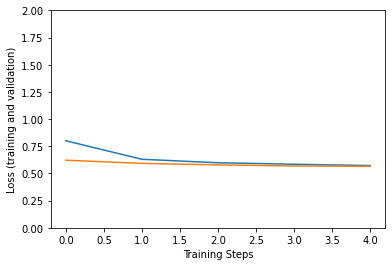

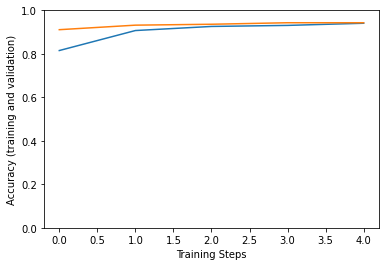

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

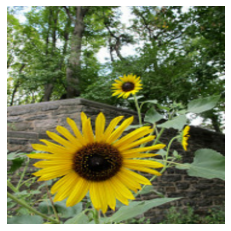

True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

2021-07-10 11:11:49.663732: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-s/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-s/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 80553236 bytes.


2021-07-10 11:12:18.591401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-07-10 11:12:18.591450: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-07-10 11:12:18.591456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-07-10 11:12:18.592361: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /tmp/saved_flowers_model_efficientnetv2-s
2021-07-10 11:12:18.733110: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-07-10 11:12:18.733153: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/saved_flowers_model_efficientnetv2-s
2021-07-10 11:12:18.733245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-10 11:12:18.733262: I tensorflow/core/co

In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 50 of 50 examples (100%).
TF Lite model is accurate on 47 of 50 examples (94%).
